In [115]:
import os, sys
from datetime import datetime
import numpy as np
import imageio
import json
import pdb
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm, trange
import pickle
import imageio.v2 as imageio
import matplotlib.pyplot as plt

from run_nerf_helpers import *
from optimizer import MultiOptimizer
from radam import RAdam
from loss import sigma_sparsity_loss, total_variation_loss

from load_llff import load_llff_data
from load_deepvoxels import load_dv_data
from load_blender import load_blender_data
from load_LINEMOD import load_LINEMOD_data
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
DEBUG = False


def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches.
    """
    if chunk is None:
        return fn
    def ret(inputs):
        return torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret


def run_network(inputs, viewdirs, fn, embed_fn, embeddirs_fn, netchunk=1024*64):
    """Prepares inputs and applies network 'fn'.
    """
    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]])
    embedded = embed_fn(inputs_flat)

    if viewdirs is not None:
        input_dirs = viewdirs[:,None].expand(inputs.shape)
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]])
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        embedded = torch.cat([embedded, embedded_dirs], -1)

    outputs_flat = batchify(fn, netchunk)(embedded)
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])
    return outputs


def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """Render rays in smaller minibatches to avoid OOM.
    """
    all_ret = {}
    for i in range(0, rays_flat.shape[0], chunk):
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])

    all_ret = {k : torch.cat(all_ret[k], 0) for k in all_ret}
    return all_ret


def render(H, W, K, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=5.,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """Render rays
    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.
      c2w: array of shape [3, 4]. Camera-to-world transformation matrix.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for
       camera while using other c2w argument for viewing directions.
    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """
    if c2w is not None:
        # special case to render full image
        rays_o, rays_d = get_rays(H, W, K, c2w)
    else:
        # use provided ray batch
        rays_o, rays_d = rays

    if use_viewdirs:
        # provide ray directions as input
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
        viewdirs = torch.reshape(viewdirs, [-1,3]).float()

    sh = rays_d.shape # [..., 3]
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)

    # Create ray batch
    rays_o = torch.reshape(rays_o, [-1,3]).float()
    rays_d = torch.reshape(rays_d, [-1,3]).float()

    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])
    rays = torch.cat([rays_o, rays_d, near, far], -1)
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1)

    # Render and reshape
    all_ret = batchify_rays(rays, chunk, **kwargs)
    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)

    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]


def render_path(render_poses, hwf, K, chunk, render_kwargs, gt_imgs=None, savedir=None, render_factor=0):

    H, W, focal = hwf

    if render_factor!=0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    rgbs = []
    disps = []
    psnrs = []

    t = time.time()
    for i, c2w in enumerate(tqdm(render_poses)):
        print(i, time.time() - t)
        t = time.time()
        rgb, disp, acc, _ = render(H, W, K, chunk=chunk, c2w=c2w[:3,:4], **render_kwargs)
        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())
        if i==0:
            print(rgb.shape, disp.shape)

        if gt_imgs is not None and render_factor==0:
            try:
                gt_img = gt_imgs[i].cpu().numpy()
            except:
                gt_img = gt_imgs[i]
            p = -10. * np.log10(np.mean(np.square(rgb.cpu().numpy() - gt_img)))
            print(p)
            psnrs.append(p)


        if savedir is not None:
            rgb8 = to8b(rgbs[-1])
            filename = os.path.join(savedir, '{:03d}.png'.format(i))
            imageio.imwrite(filename, rgb8)


    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)
    if gt_imgs is not None and render_factor==0:
        avg_psnr = sum(psnrs)/len(psnrs)
        print("Avg PSNR over Test set: ", avg_psnr)
        with open(os.path.join(savedir, "test_psnrs_avg{:0.2f}.pkl".format(avg_psnr)), "wb") as fp:
            pickle.dump(psnrs, fp)

    return rgbs, disps


def create_nerf(args):
    """Instantiate NeRF's MLP model.
    """
    embed_fn, input_ch = get_embedder(args.multires, args, i=args.i_embed)
    if args.i_embed==1:
        # hashed embedding table
        embedding_params = list(embed_fn.parameters())

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        # if using hashed for xyz, use SH for views
        embeddirs_fn, input_ch_views = get_embedder(args.multires_views, args, i=args.i_embed_views)

    output_ch = 5 if args.N_importance > 0 else 4
    skips = [4]

    if args.i_embed==1:
        model = NeRFSmall(num_layers=2,
                        hidden_dim=64,
                        geo_feat_dim=15,
                        num_layers_color=3,
                        hidden_dim_color=64,
                        input_ch=input_ch, input_ch_views=input_ch_views).to(device)
    else:
        model = NeRF(D=args.netdepth, W=args.netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
    grad_vars = list(model.parameters())

    model_fine = None

    # if args.i_embed==1:
    #     args.N_importance = 0

    if args.N_importance > 0:
        if args.i_embed==1:
            model_fine = NeRFSmall(num_layers=2,
                        hidden_dim=64,
                        geo_feat_dim=15,
                        num_layers_color=3,
                        hidden_dim_color=64,
                        input_ch=input_ch, input_ch_views=input_ch_views).to(device)
        else:
            model_fine = NeRF(D=args.netdepth_fine, W=args.netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
        grad_vars += list(model_fine.parameters())

    network_query_fn = lambda inputs, viewdirs, network_fn : run_network(inputs, viewdirs, network_fn,
                                                                embed_fn=embed_fn,
                                                                embeddirs_fn=embeddirs_fn,
                                                                netchunk=args.netchunk)

    # Create optimizer
    if args.i_embed==1:
        # sparse_opt = torch.optim.SparseAdam(embedding_params, lr=args.lrate, betas=(0.9, 0.99), eps=1e-15)
        # dense_opt = torch.optim.Adam(grad_vars, lr=args.lrate, betas=(0.9, 0.99), weight_decay=1e-6)
        # optimizer = MultiOptimizer(optimizers={"sparse_opt": sparse_opt, "dense_opt": dense_opt})
        optimizer = RAdam([
                            {'params': grad_vars, 'weight_decay': 1e-6},
                            {'params': embedding_params, 'eps': 1e-15}
                        ], lr=args.lrate, betas=(0.9, 0.99))
    else:
        optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))

    start = 0
    basedir = args.basedir
    expname = args.expname

    ##########################

    # Load checkpoints
    if args.ft_path is not None and args.ft_path!='None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])
        if args.i_embed==1:
            embed_fn.load_state_dict(ckpt['embed_fn_state_dict'])

    ##########################
    # pdb.set_trace()

    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : args.perturb,
        'N_importance' : args.N_importance,
        'network_fine' : model_fine,
        'N_samples' : args.N_samples,
        'network_fn' : model,
        'embed_fn': embed_fn,
        'use_viewdirs' : args.use_viewdirs,
        'white_bkgd' : args.white_bkgd,
        'raw_noise_std' : args.raw_noise_std,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.

    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer


def raw2outputs(raw, z_vals, rays_d, raw_noise_std=0, white_bkgd=False, pytest=False):
    """Transforms model's predictions to semantically meaningful values.
    Args:
        raw: [num_rays, num_samples along ray, 4]. Prediction from model.
        z_vals: [num_rays, num_samples along ray]. Integration time.
        rays_d: [num_rays, 3]. Direction of each ray.
    Returns:
        rgb_map: [num_rays, 3]. Estimated RGB color of a ray.
        disp_map: [num_rays]. Disparity map. Inverse of depth map.
        acc_map: [num_rays]. Sum of weights along each ray.
        weights: [num_rays, num_samples]. Weights assigned to each sampled color.
        depth_map: [num_rays]. Estimated distance to object.
    """
    raw2alpha = lambda raw, dists, act_fn=F.relu: 1.-torch.exp(-act_fn(raw)*dists)

    dists = z_vals[...,1:] - z_vals[...,:-1]
    dists = torch.cat([dists, torch.Tensor([1e10]).expand(dists[...,:1].shape)], -1)  # [N_rays, N_samples]

    dists = dists * torch.norm(rays_d[...,None,:], dim=-1)

    rgb = torch.sigmoid(raw[...,:3])  # [N_rays, N_samples, 3]
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[...,3].shape) * raw_noise_std

        # Overwrite randomly sampled data if pytest
        if pytest:
            np.random.seed(0)
            noise = np.random.rand(*list(raw[...,3].shape)) * raw_noise_std
            noise = torch.Tensor(noise)

    # sigma_loss = sigma_sparsity_loss(raw[...,3])
    alpha = raw2alpha(raw[...,3] + noise, dists)  # [N_rays, N_samples]
    # weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)), 1.-alpha + 1e-10], -1), -1)[:, :-1]
    rgb_map = torch.sum(weights[...,None] * rgb, -2)  # [N_rays, 3]

    depth_map = torch.sum(weights * z_vals, -1)
    disp_map = 1./torch.max(1e-10 * torch.ones_like(depth_map), depth_map / torch.sum(weights, -1))
    acc_map = torch.sum(weights, -1)

    if white_bkgd:
        rgb_map = rgb_map + (1.-acc_map[...,None])

    # Calculate weights sparsity loss
    try:
        entropy = Categorical(probs = torch.cat([weights, 1.0-weights.sum(-1, keepdim=True)+1e-6], dim=-1)).entropy()
    except:
        pdb.set_trace()
    sparsity_loss = entropy

    return rgb_map, disp_map, acc_map, weights, depth_map, sparsity_loss


def render_rays(ray_batch,
                network_fn,
                network_query_fn,
                N_samples,
                embed_fn=None,
                retraw=False,
                lindisp=False,
                perturb=0.,
                N_importance=0,
                network_fine=None,
                white_bkgd=False,
                raw_noise_std=0.,
                verbose=False,
                pytest=False):
    """Volumetric rendering.
    Args:
      ray_batch: array of shape [batch_size, ...]. All information necessary
        for sampling along a ray, including: ray origin, ray direction, min
        dist, max dist, and unit-magnitude viewing direction.
      network_fn: function. Model for predicting RGB and density at each point
        in space.
      network_query_fn: function used for passing queries to network_fn.
      N_samples: int. Number of different times to sample along each ray.
      retraw: bool. If True, include model's raw, unprocessed predictions.
      lindisp: bool. If True, sample linearly in inverse depth rather than in depth.
      perturb: float, 0 or 1. If non-zero, each ray is sampled at stratified
        random points in time.
      N_importance: int. Number of additional times to sample along each ray.
        These samples are only passed to network_fine.
      network_fine: "fine" network with same spec as network_fn.
      white_bkgd: bool. If True, assume a white background.
      raw_noise_std: ...
      verbose: bool. If True, print more debugging info.
    Returns:
      rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
      disp_map: [num_rays]. Disparity map. 1 / depth.
      acc_map: [num_rays]. Accumulated opacity along each ray. Comes from fine model.
      raw: [num_rays, num_samples, 4]. Raw predictions from model.
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disp_map. Output for coarse model.
      acc0: See acc_map. Output for coarse model.
      z_std: [num_rays]. Standard deviation of distances along ray for each
        sample.
    """
    N_rays = ray_batch.shape[0]
    rays_o, rays_d = ray_batch[:,0:3], ray_batch[:,3:6] # [N_rays, 3] each
    viewdirs = ray_batch[:,-3:] if ray_batch.shape[-1] > 8 else None
    bounds = torch.reshape(ray_batch[...,6:8], [-1,1,2])
    near, far = bounds[...,0], bounds[...,1] # [-1,1]

    t_vals = torch.linspace(0., 1., steps=N_samples)
    if not lindisp:
        z_vals = near * (1.-t_vals) + far * (t_vals)
    else:
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

    z_vals = z_vals.expand([N_rays, N_samples])

    if perturb > 0.:
        # get intervals between samples
        mids = .5 * (z_vals[...,1:] + z_vals[...,:-1])
        upper = torch.cat([mids, z_vals[...,-1:]], -1)
        lower = torch.cat([z_vals[...,:1], mids], -1)
        # stratified samples in those intervals
        t_rand = torch.rand(z_vals.shape)

        # Pytest, overwrite u with numpy's fixed random numbers
        if pytest:
            np.random.seed(0)
            t_rand = np.random.rand(*list(z_vals.shape))
            t_rand = torch.Tensor(t_rand)

        z_vals = lower + (upper - lower) * t_rand

    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]

#     raw = run_network(pts)
    raw = network_query_fn(pts, viewdirs, network_fn)
    rgb_map, disp_map, acc_map, weights, depth_map, sparsity_loss = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

    if N_importance > 0:

        rgb_map_0, disp_map_0, acc_map_0, sparsity_loss_0 = rgb_map, disp_map, acc_map, sparsity_loss

        z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1])
        z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance, det=(perturb==0.), pytest=pytest)
        z_samples = z_samples.detach()

        z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1)
        pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]

        run_fn = network_fn if network_fine is None else network_fine
#         raw = run_network(pts, fn=run_fn)
        raw = network_query_fn(pts, viewdirs, run_fn)

        rgb_map, disp_map, acc_map, weights, depth_map, sparsity_loss = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

    ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map, 'sparsity_loss': sparsity_loss}
    if retraw:
        ret['raw'] = raw
    if N_importance > 0:
        ret['rgb0'] = rgb_map_0
        ret['disp0'] = disp_map_0
        ret['acc0'] = acc_map_0
        ret['sparsity_loss0'] = sparsity_loss_0
        ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    for k in ret:
        if (torch.isnan(ret[k]).any() or torch.isinf(ret[k]).any()) and DEBUG:
            print(f"! [Numerical Error] {k} contains nan or inf.")

    return ret


def config_parser():


    import configargparse
    parser = configargparse.ArgumentParser()
    parser.config = 'configs/chair.txt' #'config file path'
    parser.expname = 'chair'
    parser.basedir = './logs/' #'where to store ckpts and logs'
    parser.datadir = './data/nerf_synthetic/chair' #'input data directory'
    # training options
    parser.netdepth = 8, #'layers in network'
    parser.netwidth = 256 #'channels per layer'
    parser.netdepth_fine = 8 #'layers in fine network'
    parser.netwidth_fine = 256 #'channels per layer in fine network'
    parser.N_rand = 1024#32*32*4 #'batch size (number of random rays per gradient step)'
    parser.lrate = 0.01 #5e-4 #'learning rate'
    parser.lrate_decay = 500#10 #250 #'exponential learning rate decay (in 1000 steps)'
    parser.chunk = 1024*32 #'number of rays processed in parallel, decrease if running out of memory')
    parser.netchunk = 1024*64 #'number of pts sent through network in parallel, decrease if running out of memory')
    parser.no_batching = False #'only take random rays from 1 image at a time'
    parser.no_reload = False #'do not reload weights from saved ckpt'
    parser.ft_path = None #'specific weights npy file to reload for coarse network'
    # rendering options
    parser.N_samples = 64 # 'number of coarse samples per ray'
    parser.N_importance = 128#0 #number of additional fine samples per ray'
    parser.perturb = 1. #'set to 0. for no jitter, 1. for jitter'
    parser.use_viewdirs = True #'use full 5D input instead of 3D'
    parser.i_embed = 1 #'set 1 for hashed embedding, 0 for default positional encoding, 2 for spherical')
    parser.i_embed_views = 2 #'set 1 for hashed embedding, 0 for default positional encoding, 2 for spherical')
    parser.multires = 10 #'log2 of max freq for positional encoding (3D location)')
    parser.multires_views = 4 #'log2 of max freq for positional encoding (2D direction)')
    parser.raw_noise_std = 0. #'std dev of noise added to regularize sigma_a output, 1e0 recommended')
    parser.render_only = False #'do not optimize, reload weights and render out render_poses path')
    parser.render_test = False #'render the test set instead of render_poses path')
    parser.render_factor = 0 # 'downsampling factor to speed up rendering, set 4 or 8 for fast preview')
# training options
    parser.precrop_iters = 500#0 #'number of steps to train on central crops')
    parser.precrop_frac = 0.5 # 'fraction of img taken for central crops')
    # dataset options
    parser.dataset_type = 'blender' #'options: llff / blender / deepvoxels')
    parser.testskip = 8 #'will load 1/N images from test/val sets, useful for large datasets like deepvoxels')
    ## deepvoxels flags
    parser.shape = 'greek'#'options : armchair / cube / greek / vase')
    ## blender flags
    parser.white_bkgd = True #'set to render synthetic data on a white bkgd (always use for dvoxels)')
    parser.half_res = False #'load blender synthetic data at 400x400 instead of 800x800')
    ## llff flags
    parser.factor = 8 #'downsample factor for LLFF images')
    parser.no_ndc = 'store_true' #'do not use normalized device coordinates (set for non-forward facing scenes)')
    parser.lindisp = False #'sampling linearly in disparity rather than depth')
    parser.spherify = False #'set for spherical 360 scenes')
    parser.llffhold = 8 #'will take every 1/N images as LLFF test set, paper uses 8')
    # logging/saving options
    parser.i_print = 100 #'frequency of console printout and metric loggin'
    parser.i_img = 500 #'frequency of tensorboard image logging'
    parser.i_weights = 10000 #'frequency of weight ckpt saving'
    parser.i_testset = 1000 #'frequency of testset saving')
    parser.i_video = 5000 #'frequency of render_poses video saving'
    parser.finest_res = 512 #'finest resolultion for hashed embedding'
    parser.log2_hashmap_size = 19 #'log2 of hashmap size'
    parser.sparse_loss_weight = 1e-10 #'learning rate'
    parser.tv_loss_weight = 1e-6 #'learning rate'
    return parser

def pose_spherical(param):

    theta, phi, radius = param

    phi = phi/180.*torch.pi
    th = theta/180.*torch.pi

    trans_t = torch.eye(4)
    trans_t[2][3] = radius

    rot_phi = torch.eye(4)
    rot_phi[1][1] = torch.cos(phi)
    rot_phi[1][2] = -torch.sin(phi)
    rot_phi[2][1] = torch.sin(phi)
    rot_phi[2][2] = torch.cos(phi)

    rot_theta = torch.eye(4)
    rot_theta[0][0] = torch.cos(th)
    rot_theta[0][2] = -torch.sin(th)
    rot_theta[2][0] = torch.sin(th)
    rot_theta[2][2] = torch.cos(th)

    c2w = trans_t
    c2w = rot_phi @ c2w
    c2w = rot_theta @ c2w
    c2w = torch.Tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

torch.set_default_tensor_type('torch.cuda.FloatTensor')
parser = config_parser()
args = parser

                    
# Load data
K = None
# args.dataset_type == 'blender':
images, poses, render_poses, hwf, i_split, bounding_box = load_blender_data(args.datadir, args.half_res, args.testskip)
args.bounding_box = bounding_box
print('Loaded blender', images.shape, render_poses.shape, hwf, args.datadir)
i_train, i_val, i_test = i_split

near = 2.
far = 6.

images = images[...,:3]


# Cast intrinsics to right types
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]

if K is None:
    K = np.array([[focal, 0, 0.5*W],
                [0, focal, 0.5*H],
                [0, 0, 1]])

# Create log dir and copy the config file

basedir = args.basedir
if args.i_embed==1:
    args.expname += "_hashXYZ"
elif args.i_embed==0:
    args.expname += "_posXYZ"
if args.i_embed_views==2:
    args.expname += "_sphereVIEW"
elif args.i_embed_views==0:
    args.expname += "_posVIEW"
args.expname += "_fine"+str(args.finest_res) + "_log2T"+str(args.log2_hashmap_size)
args.expname += "_lr"+str(args.lrate) + "_decay"+str(args.lrate_decay)
args.expname += "_RAdam"
if args.sparse_loss_weight > 0:
    args.expname += "_sparse" + str(args.sparse_loss_weight)
args.expname += "_TV" + str(args.tv_loss_weight)
#args.expname += datetime.now().strftime('_%H_%M_%d_%m_%Y')
expname = args.expname

os.makedirs(os.path.join(basedir, expname), exist_ok=True)
f = os.path.join(basedir, expname, 'args.txt')
with open(f, 'w') as file:
    for arg in sorted(vars(args)):
        attr = getattr(args, arg)
        file.write('{} = {}\n'.format(arg, attr))
if args.config is not None:
    f = os.path.join(basedir, expname, 'config.txt')
    with open(f, 'w') as file:
        file.write(open(args.config, 'r').read())
# Create nerf model
render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf(args)
global_step = start

bds_dict = {
        'near' : near,
        'far' : far,
    }
render_kwargs_train.update(bds_dict)
render_kwargs_test.update(bds_dict)

Loaded blender (138, 800, 800, 4) torch.Size([40, 4, 4]) [800, 800, 1111.1110311937682] ./data/nerf_synthetic/chair
Found ckpts ['./logs/chair_hashXYZ_sphereVIEW_fine512_log2T19_lr0.01_decay500_RAdam_sparse1e-10_TV1e-06/050000.tar']
Reloading from ./logs/chair_hashXYZ_sphereVIEW_fine512_log2T19_lr0.01_decay500_RAdam_sparse1e-10_TV1e-06/050000.tar
Not ndc!


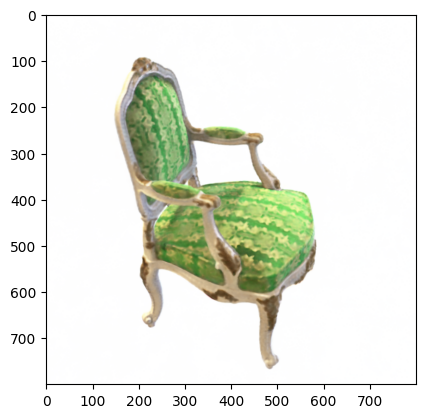

In [5]:
# render one image 
testsavedir = os.path.join(args.basedir, args.expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
os.makedirs(testsavedir, exist_ok=True)
H, W, focal = hwf
p = torch.tensor([-108.0, -30.0, 4.0])
render_poses = pose_spherical(p)
pose = torch.tensor([[-0.9250140190124512,0.2748899757862091,-0.2622683644294739,-1.0572376251220703],
                     [-0.3799331784248352,-0.6692678928375244,0.6385383605957031,2.5740303993225098],
                     [0.0,0.6903012990951538,0.7235219478607178,2.9166102409362793],
                     [0.0,0.0,0.0,1.0]])

rgbs = []
with torch.no_grad():
    c2w = torch.Tensor(render_poses).to(device) 
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, c2w=c2w[:3,:4], **render_kwargs_test)
    rgbs.append(rgb.cpu().numpy())
    rgb8 = to8b(rgbs[-1])
plt.imshow(rgb8)
plt.show()


In [25]:
# gt_pose for r_20 image in training set 
target_pose = torch.tensor([[-0.956350564956665,0.1446351855993271,-0.25391802191734314,-1.023576259613037],
                        [-0.2922220230102539,-0.4733453392982483,0.83099365234375,3.3498425483703613],
                        [7.450581485102248e-09,0.8689215779304504,0.49494966864585876,1.9952058792114258],
                        [0.0,0.0,0.0,1.0]])

# Below pose is for r_9 image in training set and close enough to gt_pose 
input_pose = torch.tensor([[-0.8507986068725586,0.20614278316497803,-0.483370304107666,-1.9485280513763428],
                           [-0.5254918932914734,-0.33375585079193115,0.7826015949249268,3.1547679901123047],
                           [1.4901161193847656e-08,0.9198436141014099,0.39228537678718567,1.581352949142456],
                           [0.0,0.0, 0.0,1.0]])
rgbs = []
with torch.no_grad():
    c2w = torch.Tensor(target_pose).to(device) 
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, c2w=c2w[:3,:4], **render_kwargs_test)
    rgbs.append(rgb.cpu().numpy())
    target_image = to8b(rgbs[-1])
rgbs = []
with torch.no_grad():
    c2w = torch.Tensor(input_pose).to(device) 
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, c2w=c2w[:3,:4], **render_kwargs_test)
    rgbs.append(rgb.cpu().numpy())
    input_image = to8b(rgbs[-1])

'''input_image = imageio.v2.imread('./input/r_20.png')
target = (np.array(input_image) / 255.).astype(np.float32)
target = torch.Tensor(target).to(device)
#target = target[...,:3]*target[...,-1:] + (1.-target[...,-1:])'''


fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(target_image)
plt.axis('off')
plt.title('Target Image')

fig.add_subplot(1, 2, 2)
plt.imshow(input_image)
plt.axis('off')
plt.title('Input Image')
plt.show()

KeyboardInterrupt: 

iter: 0, loss is 0.039864979684352875
iter: 50, loss is 0.019752686843276024
iter: 100, loss is 0.016083860769867897
iter: 150, loss is 0.01445448212325573
iter: 200, loss is 0.014304835349321365
iter: 250, loss is 0.017084240913391113
iter: 300, loss is 0.016215741634368896
iter: 350, loss is 0.014955496415495872
iter: 400, loss is 0.01647181808948517
iter: 450, loss is 0.014223188161849976
iter: 500, loss is 0.01214513462036848
iter: 550, loss is 0.016642484813928604
iter: 600, loss is 0.015027783811092377
gt_pose is:
[[-9.5635056e-01  1.4463519e-01 -2.5391802e-01 -1.0235763e+00]
 [-2.9222202e-01 -4.7334534e-01  8.3099365e-01  3.3498425e+00]
 [ 7.4505815e-09  8.6892158e-01  4.9494967e-01  1.9952059e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
pre_pose is: 
[[-0.9363653   0.2948275  -0.5115087  -1.7307092 ]
 [-0.36403897 -0.4154825   0.842986    3.1354618 ]
 [-0.01650773  1.0577557   0.43359825  1.6490461 ]
 [ 0.          0.          0.          1.        ]]


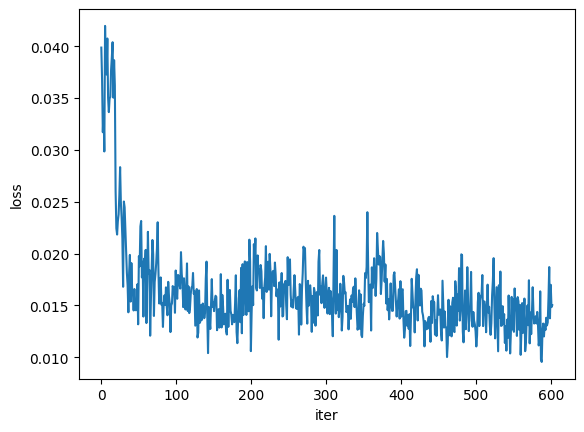

In [5]:
# optimizing camera pose directly - Random Sampling 

gt_image = (np.array(target_image) / 255.).astype(np.float32)
gt_image = torch.tensor(gt_image).to(device)

c2w = torch.Tensor(input_pose).to(device)
c2w.requires_grad = True



optimizer2 = torch.optim.Adam(params=[c2w], lr=args.lrate)

N_rand = args.N_rand

steps = 600 + 1
mse_loss = torch.nn.MSELoss()
predicted_poses = []
rendered_rgb = []
losses = []
for step in range(steps):

    rays_o, rays_d = get_rays(H, W, K, c2w[:3,:4]) # [N, ro+rd, H, W, 3]

    dH = int(H//2 * args.precrop_frac)
    dW = int(W//2 * args.precrop_frac)
    coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
    coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
    select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
    select_coords = coords[select_inds].long()  # (N_rand, 2)
    rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    batch_rays = torch.stack([rays_o, rays_d], 0)
    target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    #rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays,
                                                #verbose=0 < 10, retraw=True,
                                                #**render_kwargs_train)
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)

    optimizer2.zero_grad()
    img_loss = mse_loss(rgb, target_s)
    img_loss.backward()
    optimizer2.step()

    losses.append(torch.clone(img_loss.cpu()).detach().numpy())
    
    if step%50 ==0:
        predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
        rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
        
        print(f'iter: {step}, loss is {img_loss}')
                      
print(f'gt_pose is:')
print(torch.clone(target_pose.cpu()).detach().numpy())
print(f'pre_pose is: ')
print(predicted_poses[-1])

x = np.linspace(0,steps,steps)
plt.plot(x,losses)
plt.ylabel('loss')
plt.xlabel('iter')
plt.show()

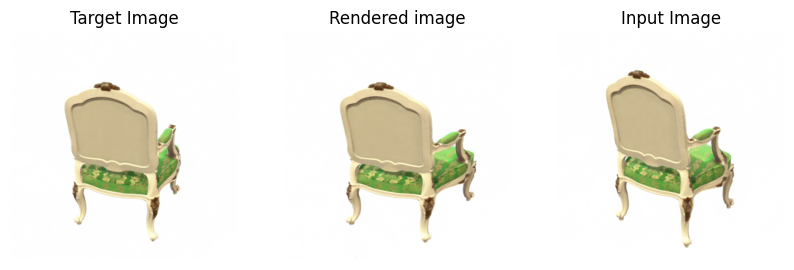

In [7]:
# render after obtimization camera pose directly - Random Sampling 
testsavedir = os.path.join(args.basedir, args.expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
os.makedirs(testsavedir, exist_ok=True)
H, W, focal = hwf
pose = torch.tensor(predicted_poses[-1])
rgbs = []
with torch.no_grad():
    c2w = torch.Tensor(pose).to(device) 
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, c2w=c2w[:3,:4], **render_kwargs_test)
    rgbs.append(rgb.cpu().numpy())
    rgb8 = to8b(rgbs[-1])
    filename = os.path.join(testsavedir, '{:03d}.png'.format(0))
    imageio.imwrite(filename, rgb8)

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(target_image)
plt.axis('off')
plt.title('Target Image')

fig.add_subplot(1, 3, 2)
plt.imshow(rgb8)
plt.axis('off')
plt.title('Rendered image')

fig.add_subplot(1, 3, 3)
plt.imshow(input_image)
plt.axis('off')
plt.title('Input Image')

plt.show()

iter: 0, loss is 0.03063722513616085
iter: 50, loss is 0.004438175354152918
iter: 100, loss is 0.0035976271610707045
iter: 150, loss is 0.0021920008584856987
iter: 200, loss is 0.0021845055744051933
iter: 250, loss is 0.0021132719703018665
iter: 300, loss is 0.002111605368554592
iter: 350, loss is 0.0023781280033290386
iter: 400, loss is 0.0021098784636706114
iter: 450, loss is 0.0019208727171644568
iter: 500, loss is 0.0019468944519758224
iter: 550, loss is 0.0024113813415169716
iter: 600, loss is 0.0018229413544759154
gt_pose is:
[[-9.5635056e-01  1.4463519e-01 -2.5391802e-01 -1.0235763e+00]
 [-2.9222202e-01 -4.7334534e-01  8.3099365e-01  3.3498425e+00]
 [ 7.4505815e-09  8.6892158e-01  4.9494967e-01  1.9952059e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
pre_pose is: 
[[-1.1544478   0.33240727 -0.5963782  -1.6463934 ]
 [-0.42979714 -0.4089487   0.9750293   2.9631782 ]
 [ 0.01023938  1.3784232   0.494662    1.5487682 ]
 [ 0.          0.          0.          1. 

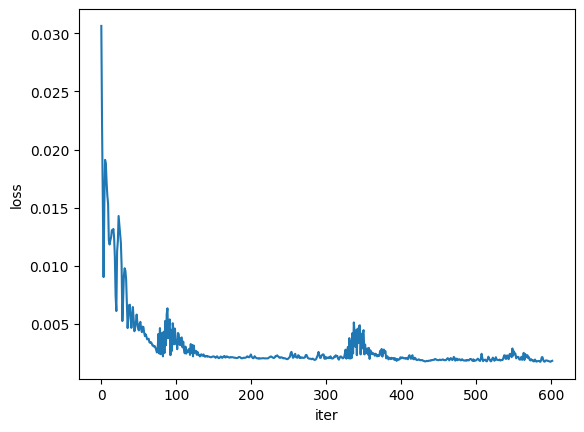

In [7]:
# optimizing camera pose directly - Random Sampling with lower args.precrop_frac / box - random outside of the loop 

gt_image = (np.array(target_image) / 255.).astype(np.float32)
gt_image = torch.tensor(gt_image).to(device)

c2w = torch.Tensor(input_pose).to(device)
c2w.requires_grad = True


args.precrop_frac = 0.3
optimizer2 = torch.optim.Adam(params=[c2w], lr=args.lrate)

N_rand = args.N_rand

steps = 600 + 1
mse_loss = torch.nn.MSELoss()
predicted_poses = []
rendered_rgb = []
losses = []

dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)
coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
select_coords = coords[select_inds].long()  # (N_rand, 2)

for step in range(steps):

    rays_o, rays_d = get_rays(H, W, K, c2w[:3,:4]) # [N, ro+rd, H, W, 3]


    rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    batch_rays = torch.stack([rays_o, rays_d], 0)
    target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    #rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays,
                                                #verbose=0 < 10, retraw=True,
                                                #**render_kwargs_train)
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)

    optimizer2.zero_grad()
    img_loss = mse_loss(rgb, target_s)
    img_loss.backward()
    optimizer2.step()

    losses.append(torch.clone(img_loss.cpu()).detach().numpy())
    
    if step%50 ==0:
        predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
        rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
        
        print(f'iter: {step}, loss is {img_loss}')
                      
print(f'gt_pose is:')
print(torch.clone(target_pose.cpu()).detach().numpy())
print(f'pre_pose is: ')
print(predicted_poses[-1])

x = np.linspace(0,steps,steps)
plt.plot(x,losses)
plt.ylabel('loss')
plt.xlabel('iter')
plt.show()

In [8]:
# render after obtimization camera pose directly - Random Sampling 
testsavedir = os.path.join(args.basedir, args.expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
os.makedirs(testsavedir, exist_ok=True)
H, W, focal = hwf
pose = torch.tensor(predicted_poses[-1])
rgbs = []
with torch.no_grad():
    c2w = torch.Tensor(pose).to(device) 
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, c2w=c2w[:3,:4], **render_kwargs_test)
    rgbs.append(rgb.cpu().numpy())
    rgb8 = to8b(rgbs[-1])
    filename = os.path.join(testsavedir, '{:03d}.png'.format(0))
    imageio.imwrite(filename, rgb8)

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(target_image)
plt.axis('off')
plt.title('Target Image')

fig.add_subplot(1, 3, 2)
plt.imshow(rgb8)
plt.axis('off')
plt.title('Rendered image')

fig.add_subplot(1, 3, 3)
plt.imshow(input_image)
plt.axis('off')
plt.title('Input Image')

plt.show()

> /home/eph133/HashNeRF/utils.py(106)get_voxel_vertices()
    104         # print("ALERT: some points are outside bounding box. Clipping them!")
    105         pdb.set_trace()
--> 106         xyz = torch.clamp(xyz, min=box_min, max=box_max)
    107 
    108     grid_size = (box_max-box_min)/resolution



In [20]:
# verification for loss function with gt_pose and gt_image

gt_pose = torch.tensor([[-0.956350564956665,0.1446351855993271,-0.25391802191734314,-1.023576259613037],
                        [-0.2922220230102539,-0.4733453392982483,0.83099365234375,3.3498425483703613],
                        [7.450581485102248e-09,0.8689215779304504,0.49494966864585876,1.9952058792114258],
                        [0.0,0.0,0.0,1.0]])

c2w = torch.Tensor(gt_pose).to(device)
c2w.requires_grad = True 
optimizer2 = torch.optim.Adam(params=[c2w], lr=args.lrate)

input_image = imageio.v2.imread('./input/1.png')
target = (np.array(input_image) / 255.).astype(np.float32)
target = torch.Tensor(target).to(device)
target = target[...,:3]*target[...,-1:] + (1.-target[...,-1:])

N_rand = args.N_rand

steps = 450 + 1
mse_loss = torch.nn.MSELoss()

rays_o, rays_d = get_rays(H, W, K, c2w[:3,:4]) # [N, ro+rd, H, W, 3]

dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)
coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
select_coords = coords[select_inds].long()  # (N_rand, 2)
rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
batch_rays = torch.stack([rays_o, rays_d], 0)
target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
#rgbs, _ = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test, gt_imgs=images, savedir=testsavedir, render_factor=args.render_factor)
rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
#rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays,
                                                #verbose=0 < 10, retraw=True,
                                                #**render_kwargs_train)
optimizer2.zero_grad()
img_loss = mse_loss(rgb, target_s)
img_loss.backward()
optimizer2.step()
print(img_loss)


tensor(0.0443, grad_fn=<MseLossBackward0>)


In [27]:
# Verification for target image and gt_pose 
gt_pose = torch.tensor([[-0.956350564956665,0.1446351855993271,-0.25391802191734314,-1.023576259613037],
                        [-0.2922220230102539,-0.4733453392982483,0.83099365234375,3.3498425483703613],
                        [7.450581485102248e-09,0.8689215779304504,0.49494966864585876,1.9952058792114258],
                        [0.0,0.0,0.0,1.0]])

testsavedir = os.path.join(args.basedir, args.expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
os.makedirs(testsavedir, exist_ok=True)
H, W, focal = hwf

rgbs = []
with torch.no_grad():
    c2w = torch.Tensor(gt_pose).to(device) 
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, c2w=c2w[:3,:4], **render_kwargs_test)
    rgbs.append(rgb.cpu().numpy())
    rgb8 = to8b(rgbs[-1])
    filename = os.path.join(testsavedir, '{:03d}.png'.format(0))
    imageio.imwrite(filename, rgb8)
    

input_image = imageio.v2.imread('./input/1.png')
target = (np.array(input_image) / 255.).astype(np.float32)
target = torch.Tensor(target).to(device)
#target = target[...,:3]*target[...,-1:] + (1.-target[...,-1:])

rgbs = []

rgbs.append(target.cpu().numpy())
rgb8 = to8b(rgbs[-1])
filename = os.path.join(testsavedir, '{:03d}.png'.format(1))
imageio.imwrite(filename, rgb8)

iter: 0, loss is 0.04178193211555481
iter: 200, loss is 0.03904956579208374
iter: 400, loss is 0.034933801740407944
iter: 600, loss is 0.03281409293413162
iter: 800, loss is 0.029341721907258034
iter: 1000, loss is 0.022677958011627197
iter: 1200, loss is 0.011854208074510098
iter: 1400, loss is 0.0023316398728638887
iter: 1600, loss is 0.0021129550877958536
iter: 1800, loss is 0.0021129653323441744


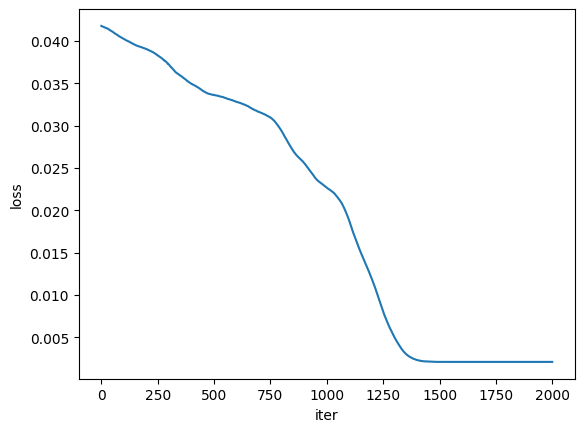

In [25]:
# optimizing just theta
def pose_spherical(param):

    theta = param
    phi = torch.Tensor([-30.0])
    radius = torch.Tensor([4.0])

    phi = phi/180.*torch.pi
    th = theta/180.*torch.pi

    trans_t = torch.eye(4)
    trans_t[2][3] = radius

    rot_phi = torch.eye(4)
    rot_phi[1][1] = torch.cos(phi)
    rot_phi[1][2] = -torch.sin(phi)
    rot_phi[2][1] = torch.sin(phi)
    rot_phi[2][2] = torch.cos(phi)

    rot_theta = torch.eye(4)
    rot_theta[0][0] = torch.cos(th)
    rot_theta[0][2] = -torch.sin(th)
    rot_theta[2][0] = torch.sin(th)
    rot_theta[2][2] = torch.cos(th)

    c2w = trans_t
    c2w = rot_phi @ c2w
    c2w = rot_theta @ c2w
    c2w = torch.Tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

gt_image = (np.array(target_image) / 255.).astype(np.float32)
gt_image = torch.tensor(gt_image).to(device)
args.precrop_frac = 0.5
#param = torch.tensor([0.0, -30.0, 4.0])
param = torch.tensor([0.0])#, -30.0, 4.0])
param.requires_grad = True 

optimizer2 = torch.optim.Adam(params=[param], lr=args.lrate)
N_rand = 4000 #args.N_rand
steps = 2000
mse_loss = torch.nn.MSELoss()
predicted_poses = []
rendered_rgb = []
losses = []
rendered_param = []

dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)
coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
select_coords = coords[select_inds].long()  # (N_rand, 2)

for step in range(steps):
    render_poses = pose_spherical(param)
    c2w = torch.Tensor(render_poses).to(device)
    rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

    rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    batch_rays = torch.stack([rays_o, rays_d], 0)
    target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
    optimizer2.zero_grad()
    img_loss = mse_loss(rgb, target_s)
    img_loss.backward()
    optimizer2.step()
    losses.append(torch.clone(img_loss.cpu()).detach().numpy())
    if step%200 == 0:
        predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
        rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
        rendered_param.append(torch.clone(param.cpu()).detach().numpy())
        print(f'iter: {step}, loss is {img_loss}')

x = np.linspace(0,steps,steps)
plt.plot(x,losses)
plt.ylabel('loss')
plt.xlabel('iter')
plt.show()

In [18]:
print('predicted pose: ')
print(predicted_poses[-1])
param = torch.tensor([-14])
render_poses = pose_spherical(param)
print('Ground truth pose')
print(target_pose)

predicted pose: 
[[-0.95696855  0.14509583 -0.25131333 -1.0052533 ]
 [-0.29019165 -0.47848427  0.8287591   3.3150363 ]
 [ 0.          0.8660254   0.5         2.        ]
 [ 0.          0.          0.          1.        ]]
Ground truth pose
tensor([[-9.5635e-01,  1.4464e-01, -2.5392e-01, -1.0236e+00],
        [-2.9222e-01, -4.7335e-01,  8.3099e-01,  3.3498e+00],
        [ 7.4506e-09,  8.6892e-01,  4.9495e-01,  1.9952e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


In [11]:
# after optimization - rendering for optimizing theta 
parm = torch.tensor(rendered_param[-1])
render_poses = torch.stack([pose_spherical(parm)[:-1]], 0)
c2w = torch.Tensor(render_poses).to(device)
rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

rgbs = []
with torch.no_grad():
    rays = torch.stack([rays_o, rays_d], 0)
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=rays, **render_kwargs_test)

    rgbs.append(rgb.cpu().numpy())
    rgb8 = to8b(rgbs[-1])


param = torch.tensor([0.0])#[-7.0, -30.0, 4.0])
render_poses = torch.stack([pose_spherical(param)[:-1]], 0)
c2w = torch.Tensor(render_poses).to(device)
rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

rgbs = []
with torch.no_grad():
    rays = torch.stack([rays_o, rays_d], 0)
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=rays, **render_kwargs_test)

    rgbs.append(rgb.cpu().numpy())
    input_image = to8b(rgbs[-1])

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(target_image)
plt.axis('off')
plt.title('Target Image')

fig.add_subplot(1, 3, 2)
plt.imshow(rgb8)
plt.axis('off')
plt.title('Rendered image')

fig.add_subplot(1, 3, 3)
plt.imshow(input_image)
plt.axis('off')
plt.title('Input Image')

plt.show()

# save images
testsavedir = os.path.join(args.basedir, args.expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
os.makedirs(testsavedir, exist_ok=True)

filename = os.path.join(testsavedir, '{:03d}.png'.format(0))
imageio.imwrite(filename, target_image)
filename = os.path.join(testsavedir, '{:03d}.png'.format(1))
imageio.imwrite(filename, rgb8)
filename = os.path.join(testsavedir, '{:03d}.png'.format(2))
imageio.imwrite(filename, input_image)

ValueError: not enough values to unpack (expected 3, got 1)

iter: 0, loss is 0.03274187445640564
iter: 200, loss is 0.028028324246406555
iter: 400, loss is 0.021329328417778015
iter: 600, loss is 0.013502947054803371
iter: 800, loss is 0.002270015422254801
iter: 1000, loss is 6.757452865713276e-06
iter: 1200, loss is 6.633403245359659e-06
iter: 1400, loss is 6.672520157735562e-06
iter: 1600, loss is 6.637092610617401e-06
iter: 1800, loss is 6.666162789770169e-06


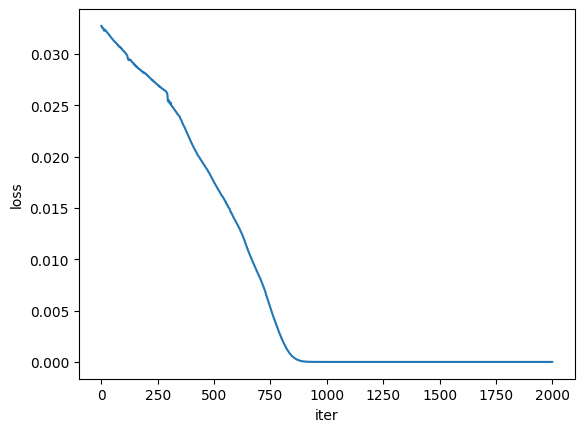

In [53]:
# optimizing theta, phi, radius 
def pose_spherical(param):

    theta, phi, radius = param

    phi = phi/180.*torch.pi
    th = theta/180.*torch.pi

    trans_t = torch.eye(4)
    trans_t[2][3] = radius

    rot_phi = torch.eye(4)
    rot_phi[1][1] = torch.cos(phi)
    rot_phi[1][2] = -torch.sin(phi)
    rot_phi[2][1] = torch.sin(phi)
    rot_phi[2][2] = torch.cos(phi)

    rot_theta = torch.eye(4)
    rot_theta[0][0] = torch.cos(th)
    rot_theta[0][2] = -torch.sin(th)
    rot_theta[2][0] = torch.sin(th)
    rot_theta[2][2] = torch.cos(th)

    c2w = trans_t
    c2w = rot_phi @ c2w
    c2w = rot_theta @ c2w
    c2w = torch.Tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

gt_image = (np.array(target_image) / 255.).astype(np.float32)
gt_image = torch.tensor(gt_image)
args.precrop_frac = 0.5

#param = torch.tensor([0.0, -30.0, 4.0]) good initial value
param = torch.tensor([-7.0, -30.0, 4.0]).to(device)
param.requires_grad = True 

optimizer2 = torch.optim.Adam(params=[param], lr=args.lrate)
N_rand = 4000 #args.N_rand
steps = 2000
mse_loss = torch.nn.MSELoss()
predicted_poses = []
rendered_rgb = []
losses = []
rendered_param = []


dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)
coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
select_coords = coords[select_inds].long()  # (N_rand, 2)

for step in range(steps):
    render_poses = pose_spherical(param)
    c2w = torch.Tensor(render_poses).to(device)
    rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

    rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    batch_rays = torch.stack([rays_o, rays_d], 0)
    target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
    optimizer2.zero_grad()
    img_loss = mse_loss(rgb, target_s)
    img_loss.backward()
    optimizer2.step()
    losses.append(torch.clone(img_loss.cpu()).detach().numpy())
    if step%200 == 0:
        predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
        rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
        rendered_param.append(torch.clone(param.cpu()).detach().numpy())
        print(f'iter: {step}, loss is {img_loss}')

x = np.linspace(0,steps,steps)
plt.plot(x,losses)
plt.ylabel('loss')
plt.xlabel('iter')
plt.show()

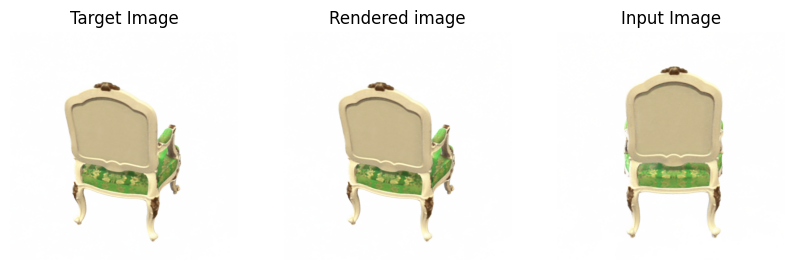

In [ ]:
# after optimization - rendering for optimizing theta, phi, radius 
parm = torch.tensor(rendered_param[-1])
render_poses = torch.stack([pose_spherical(parm)[:-1]], 0)
c2w = torch.Tensor(render_poses).to(device)
rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

rgbs = []
with torch.no_grad():
    rays = torch.stack([rays_o, rays_d], 0)
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=rays, **render_kwargs_test)

    rgbs.append(rgb.cpu().numpy())
    rgb8 = to8b(rgbs[-1])


param = torch.tensor([0.0, -20.0, 4.0])
render_poses = torch.stack([pose_spherical(param)[:-1]], 0)
c2w = torch.Tensor(render_poses).to(device)
rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

rgbs = []
with torch.no_grad():
    rays = torch.stack([rays_o, rays_d], 0)
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=rays, **render_kwargs_test)

    rgbs.append(rgb.cpu().numpy())
    input_image = to8b(rgbs[-1])

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(target_image)
plt.axis('off')
plt.title('Target Image')

fig.add_subplot(1, 3, 2)
plt.imshow(rgb8)
plt.axis('off')
plt.title('Rendered image')

fig.add_subplot(1, 3, 3)
plt.imshow(input_image)
plt.axis('off')
plt.title('Input Image')

plt.show()

# save images
testsavedir = os.path.join(args.basedir, args.expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
os.makedirs(testsavedir, exist_ok=True)

filename = os.path.join(testsavedir, '{:03d}.png'.format(0))
imageio.imwrite(filename, target_image)
filename = os.path.join(testsavedir, '{:03d}.png'.format(1))
imageio.imwrite(filename, rgb8)
filename = os.path.join(testsavedir, '{:03d}.png'.format(2))
imageio.imwrite(filename, input_image)

In [27]:
import graphviz
from graphviz import Digraph
from torchviz import make_dot

make_dot(img_loss)
make_dot(img_loss).render("attached", format="png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.591409 to fit


'attached.png'

In [12]:
# optimizing theta, phi, radius for a consecutive keyframes - N_rand = 500
def pose_spherical(param):

    theta, phi, radius = param

    phi = phi/180.*torch.pi
    th = theta/180.*torch.pi

    trans_t = torch.eye(4)
    trans_t[2][3] = radius

    rot_phi = torch.eye(4)
    rot_phi[1][1] = torch.cos(phi)
    rot_phi[1][2] = -torch.sin(phi)
    rot_phi[2][1] = torch.sin(phi)
    rot_phi[2][2] = torch.cos(phi)

    rot_theta = torch.eye(4)
    rot_theta[0][0] = torch.cos(th)
    rot_theta[0][2] = -torch.sin(th)
    rot_theta[2][0] = torch.sin(th)
    rot_theta[2][2] = torch.cos(th)

    c2w = trans_t
    c2w = rot_phi @ c2w
    c2w = rot_theta @ c2w
    c2w = torch.Tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

# input images are from logs folder, 008, 009, 010, 011, 012, 013, 014, 015 
args.lrate = 0.1 #0.15
import imageio.v2 as imageio
imgs = []
for i in range(1,9):
    fname = os.path.join('./input/', '00' + str(i)+ '.png')
    imgs.append(imageio.imread(fname))
imgs = (np.array(imgs) / 255.).astype(np.float32)
imgs = torch.tensor(imgs).to(device)

'''N_frames = 8
all_imgs = []
imgs = []
for n in range(0, N_frames): 
    fname = os.path.join('./input/new/', 'r_' + str(n)+ '.png')
    imgs.append(imageio.imread(fname))
#imgs.append(imageio.imread('./input/new/r_0.png'))
imgs = (np.array(imgs) / 255.).astype(np.float32)
all_imgs.append(imgs)
imgs = np.concatenate(all_imgs, 0)
imgs = imgs[...,:3]*imgs[...,-1:] + (1.-imgs[...,-1:])
imgs = torch.tensor(imgs).to(device)'''

# for white background 
#imgs = imgs[...,:3]*imgs[...,-1:] + (1.-imgs[...,-1:])


N_rand = 500 #args.N_rand

args.precrop_frac = 0.5
dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)

coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
select_coords = coords[select_inds].long()  # (N_rand, 2)

#init_param = torch.tensor([0.0, -47.23, 4.0])
init_param = torch.tensor([-108.0, -30.0, 4.0])
est_params = []

steps = 140 + 1
all_losses = np.zeros((7,steps))
losses = np.zeros((8,steps))
for i in range(1,8):
    print(f'start image number {i}:')
    gt_image = imgs[i]

    #param = torch.tensor([0.0, -30.0, 4.0]) good initial value
    param = init_param.to(device)
    param.requires_grad = True 

    optimizer2 = torch.optim.Adam(params=[param], lr=args.lrate)
    
    mse_loss = torch.nn.MSELoss()
    predicted_poses = []
    rendered_rgb = []
    rendered_param = []
    for step in range(steps):
        render_poses = pose_spherical(param)
        c2w = torch.Tensor(render_poses).to(device)
        rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

        rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        batch_rays = torch.stack([rays_o, rays_d], 0)
        target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

        rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
        optimizer2.zero_grad()
        img_loss = mse_loss(rgb, target_s)
        img_loss.backward()
        optimizer2.step()
        #losses.append(torch.clone(img_loss.cpu()).detach().numpy())
        losses[i,step] = torch.clone(img_loss.cpu()).detach().numpy()
        if step%20 == 0:
            predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
            rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
            rendered_param.append(torch.clone(param.cpu()).detach().numpy())
            print(f'iter: {step}, loss is {img_loss}')
    est_params.append(rendered_param[-1])
    init_param = torch.tensor(rendered_param[-1])


start image number 1:
iter: 0, loss is 0.03058253414928913
iter: 20, loss is 0.026359787210822105
iter: 40, loss is 0.02129758521914482
iter: 60, loss is 0.011467460542917252
iter: 80, loss is 0.0006077193538658321
iter: 100, loss is 0.00044690791401080787
iter: 120, loss is 0.00017149098857771605
iter: 140, loss is 0.00017484444833826274
start image number 2:
iter: 0, loss is 0.03503107652068138
iter: 20, loss is 0.029046030715107918
iter: 40, loss is 0.020842408761382103
iter: 60, loss is 0.013989641331136227
iter: 80, loss is 0.0007649242179468274
iter: 100, loss is 0.00033563972101546824
iter: 120, loss is 0.0002033601194852963
iter: 140, loss is 0.00014716555597260594
start image number 3:
iter: 0, loss is 0.03250567615032196
iter: 20, loss is 0.02486720308661461
iter: 40, loss is 0.023219771683216095
iter: 60, loss is 0.020520107820630074
iter: 80, loss is 0.013571937568485737
iter: 100, loss is 0.00095252605387941
iter: 120, loss is 0.00012028664059471339
iter: 140, loss is 0.00

In [56]:
# optimizing theta, phi, radius for a consecutive keyframes - N_rand = 2000
def pose_spherical(param):

    theta, phi, radius = param

    phi = phi/180.*torch.pi
    th = theta/180.*torch.pi

    trans_t = torch.eye(4)
    trans_t[2][3] = radius

    rot_phi = torch.eye(4)
    rot_phi[1][1] = torch.cos(phi)
    rot_phi[1][2] = -torch.sin(phi)
    rot_phi[2][1] = torch.sin(phi)
    rot_phi[2][2] = torch.cos(phi)

    rot_theta = torch.eye(4)
    rot_theta[0][0] = torch.cos(th)
    rot_theta[0][2] = -torch.sin(th)
    rot_theta[2][0] = torch.sin(th)
    rot_theta[2][2] = torch.cos(th)

    c2w = trans_t
    c2w = rot_phi @ c2w
    c2w = rot_theta @ c2w
    c2w = torch.Tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

# input images are from logs folder, 008, 009, 010, 011, 012, 013, 014, 015 

imgs = []
for i in range(1,9):
    fname = os.path.join('./input/', '00' + str(i)+ '.png')
    imgs.append(imageio.imread(fname))
imgs = (np.array(imgs) / 255.).astype(np.float32)
imgs = torch.tensor(imgs).to(device)

args.precrop_frac = 0.5
dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)
N_rand = 2000 
coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
select_coords = coords[select_inds].long()  # (N_rand, 2)

init_param = torch.tensor([-108.0, -30.0, 4.0])
est_params = []
steps = 1000 + 1
all_losses = np.zeros((7,steps))
losses = np.zeros((8,steps))
for i in range(1,8):
    print(f'start image number {i}:')
    gt_image = imgs[i]
    args.precrop_frac = 0.5

    #param = torch.tensor([0.0, -30.0, 4.0]) good initial value
    param = init_param.to(device)
    param.requires_grad = True 

    optimizer2 = torch.optim.Adam(params=[param], lr=args.lrate)
    
    steps = 1000 + 1 
    mse_loss = torch.nn.MSELoss()
    predicted_poses = []
    rendered_rgb = []
    
    rendered_param = []

    for step in range(steps):
        render_poses = pose_spherical(param)
        c2w = torch.Tensor(render_poses).to(device)
        rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

        rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        batch_rays = torch.stack([rays_o, rays_d], 0)
        target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

        rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
        optimizer2.zero_grad()
        img_loss = mse_loss(rgb, target_s)
        img_loss.backward()
        optimizer2.step()
        #losses.append(torch.clone(img_loss.cpu()).detach().numpy())
        losses[i,step] = torch.clone(img_loss.cpu()).detach().numpy()
        if step%200 == 0:
            predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
            rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
            rendered_param.append(torch.clone(param.cpu()).detach().numpy())
            print(f'iter: {step}, loss is {img_loss}')
    est_params.append(rendered_param[-1])
    init_param = torch.tensor(rendered_param[-1])


start image number 1:
iter: 0, loss is 0.029811803251504898
iter: 200, loss is 0.022720053791999817
iter: 400, loss is 0.01714385487139225
iter: 600, loss is 0.007151091005653143
iter: 800, loss is 0.00012029830395476893
iter: 1000, loss is 0.00011765176896005869
start image number 2:
iter: 0, loss is 0.032443903386592865
iter: 200, loss is 0.027582550421357155
iter: 400, loss is 0.01951281912624836
iter: 600, loss is 0.008297083899378777
iter: 800, loss is 0.00021497714624274522
iter: 1000, loss is 0.00010402620682725683
start image number 3:
iter: 0, loss is 0.033889804035425186
iter: 200, loss is 0.02861921675503254
iter: 400, loss is 0.024014439433813095
iter: 600, loss is 0.012846364639699459
iter: 800, loss is 9.521357424091548e-05
iter: 1000, loss is 9.040796430781484e-05
start image number 4:
iter: 0, loss is 0.03279919922351837
iter: 200, loss is 0.0293028112500906
iter: 400, loss is 0.02928096428513527
iter: 600, loss is 0.029265552759170532
iter: 800, loss is 0.0292543079704

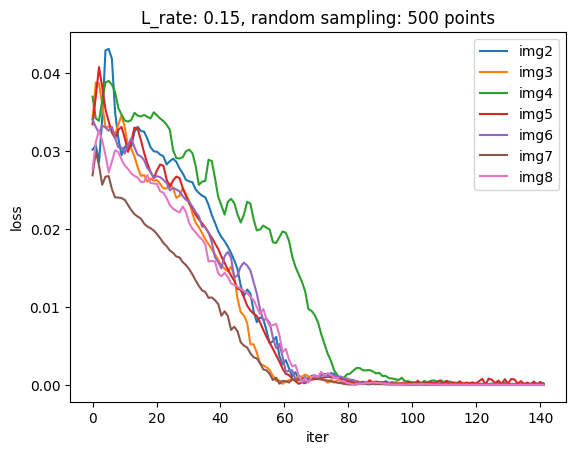

[array([-99.07266 , -29.921688,   4.000784], dtype=float32),
 array([-90.05159, -29.98865,   4.00306], dtype=float32),
 array([-81.08208 , -29.995922,   4.004321], dtype=float32),
 array([-72.06861 , -29.966488,   4.010606], dtype=float32),
 array([-63.051273 , -29.972916 ,   3.9980578], dtype=float32),
 array([-54.078255 , -29.95351  ,   4.0000544], dtype=float32),
 array([-45.078655 , -29.975718 ,   4.0004787], dtype=float32)]

In [176]:
# plot for optimizing theta, phi, radius for a consecutive keyframes - smapling 4000 point for each image 
x = np.linspace(0,steps,steps)
xx = np.zeros((7,141))
for i in range(0,7):
    xx[i,:] = x
plt.plot(x, losses[1,:],x, losses[2,:],x, losses[3,:],x, losses[4,:],x, losses[5,:],x, losses[6,:],x, losses[7,:])
plt.ylabel('loss')
plt.xlabel('iter')
plt.legend(('img2','img3','img4','img5','img6','img7','img8'))
plt.title(f'L_rate: {args.lrate}, random sampling: {N_rand} points')
plt.show()
gt_param = np.array([-99., -90.0, -81.,-72.,-63.,-54.,-45.])
est_params

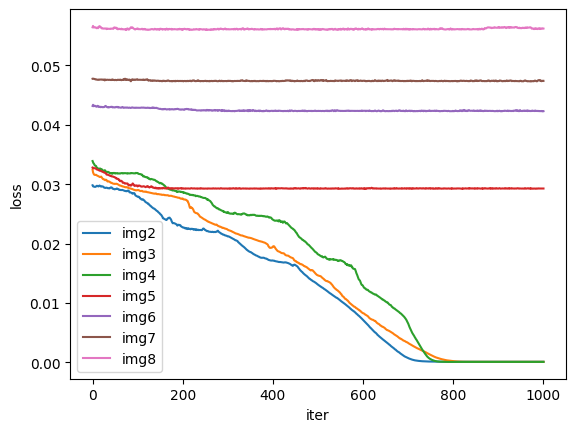

[array([-99.04601  , -29.96657  ,   4.0006666], dtype=float32),
 array([-90.05076  , -29.96498  ,   4.0006804], dtype=float32),
 array([-81.05207 , -29.965849,   4.000117], dtype=float32),
 array([-79.8381  , -29.93951 ,   4.001758], dtype=float32),
 array([-80.22729  , -29.003782 ,   3.9721513], dtype=float32),
 array([-80.813126, -29.048643,   3.973141], dtype=float32),
 array([-80.09836 , -29.284187,   4.002794], dtype=float32)]

In [57]:
# plot for optimizing theta, phi, radius for a consecutive keyframes - smapling 2000 point for each image 
x = np.linspace(0,steps,steps)
xx = np.zeros((7,1001))
for i in range(0,7):
    xx[i,:] = x
plt.plot(x, losses[1,:],x, losses[2,:],x, losses[3,:],x, losses[4,:],x, losses[5,:],x, losses[6,:],x, losses[7,:])
plt.ylabel('loss')
plt.xlabel('iter')
plt.legend(('img2','img3','img4','img5','img6','img7','img8'))
plt.show()
gt_param = np.array([-99., -90.0, -81.,-72.,-63.,-54.,-45.])
est_params

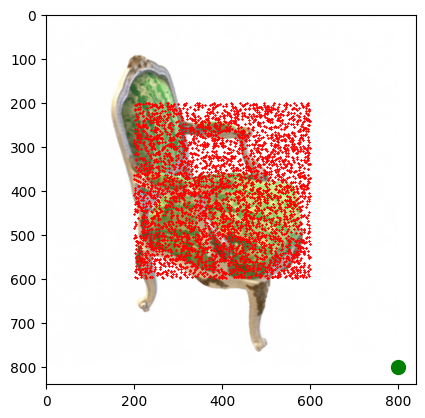

In [50]:
# plotting sampling points - 4000 sample points 
image = torch.clone(imgs[0].cpu()).detach().numpy()
pts = torch.clone(select_coords.cpu()).detach().numpy()

plt.imshow(image)
plt.plot(800, 800, "og", markersize=10)  # og:shorthand for green circle
plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=0.5)
plt.show()

select_coords.shape
target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]

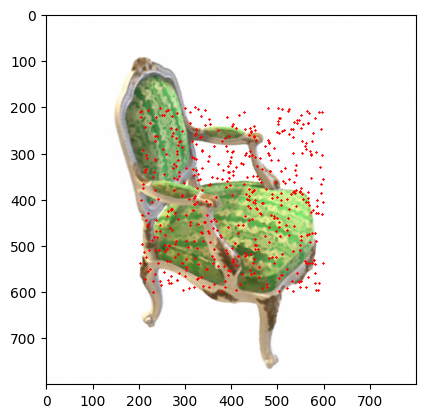

In [177]:
# plotting sampling points - 500 sample points 
image = torch.clone(imgs[0].cpu()).detach().numpy()
pts = torch.clone(select_coords.cpu()).detach().numpy()

plt.imshow(image)
#plt.plot(800, 800, "og", markersize=10)  # og:shorthand for green circle
plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=0.5)
plt.show()

select_coords.shape
target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]

In [81]:
# optimizing theta, phi, radius - grid sampling 

def pose_spherical(param):

    theta, phi, radius = param

    phi = phi/180.*torch.pi
    th = theta/180.*torch.pi

    trans_t = torch.eye(4)
    trans_t[2][3] = radius

    rot_phi = torch.eye(4)
    rot_phi[1][1] = torch.cos(phi)
    rot_phi[1][2] = -torch.sin(phi)
    rot_phi[2][1] = torch.sin(phi)
    rot_phi[2][2] = torch.cos(phi)

    rot_theta = torch.eye(4)
    rot_theta[0][0] = torch.cos(th)
    rot_theta[0][2] = -torch.sin(th)
    rot_theta[2][0] = torch.sin(th)
    rot_theta[2][2] = torch.cos(th)

    c2w = trans_t
    c2w = rot_phi @ c2w
    c2w = rot_theta @ c2w
    c2w = torch.Tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

gt_image = (np.array(target_image) / 255.).astype(np.float32)
gt_image = torch.tensor(gt_image)
args.precrop_frac = 0.5

#param = torch.tensor([0.0, -30.0, 4.0]) good initial value
param = torch.tensor([-7.0, -30.0, 4.0]).to(device)
param.requires_grad = True 

optimizer2 = torch.optim.Adam(params=[param], lr=args.lrate)
N_rand = 4000 #args.N_rand
steps = 2000
mse_loss = torch.nn.MSELoss()
predicted_poses = []
rendered_rgb = []
losses = []
rendered_param = []


dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)
coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
select_coords = coords[select_inds].long()  # (N_rand, 2)

for step in range(steps):
    render_poses = pose_spherical(param)
    c2w = torch.Tensor(render_poses).to(device)
    rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

    rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    batch_rays = torch.stack([rays_o, rays_d], 0)
    target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
    optimizer2.zero_grad()
    img_loss = mse_loss(rgb, target_s)
    img_loss.backward()
    optimizer2.step()
    losses.append(torch.clone(img_loss.cpu()).detach().numpy())
    if step%200 == 0:
        predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
        rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
        rendered_param.append(torch.clone(param.cpu()).detach().numpy())
        print(f'iter: {step}, loss is {img_loss}')

x = np.linspace(0,steps,steps)
plt.plot(x,losses)
plt.ylabel('loss')
plt.xlabel('iter')
plt.show()

iter: 0, loss is 0.032558705657720566


KeyboardInterrupt: 

In [ ]:
# grid sampling example 
import torch

input = torch.arange(8*8).view(1, 1, 8, 8).float()
# Create grid to upsample input
d = torch.linspace(-1, 1, 4)
meshx, meshy = torch.meshgrid((d, d+1))
grid = torch.stack((meshy, meshx), 2)
grid = grid.unsqueeze(0) # add batch dim

output = torch.nn.functional.grid_sample(input, grid, align_corners=True)

print(f'input: {input}')
print(f'output: {output}')

start image number 1:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


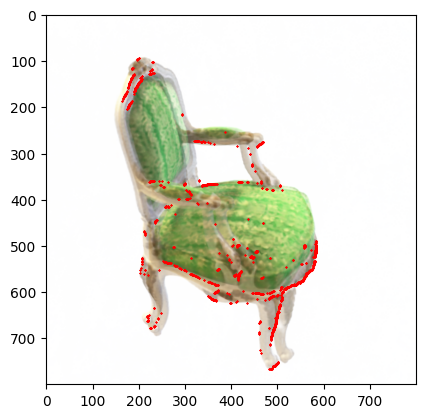

loss for sampling points is : 0.006208358332514763
iter: 0, loss is 0.017755325883626938


In [153]:
# Interesting points sampling - N_rand = 1000

# input images are from logs folder, 008, 009, 010, 011, 012, 013, 014, 015 
imgs = []
for i in range(1,9):
    fname = os.path.join('./input/', '00' + str(i)+ '.png')
    imgs.append(imageio.imread(fname))
imgs = (np.array(imgs) / 255.).astype(np.float32)
imgs = torch.tensor(imgs).to(device)

init_param = torch.tensor([-108.0, -30.0, 4.0])
est_params = []
steps = 1 + 1
N_rand = 1000 
losses = np.zeros((8,steps))
for i in range(1,2):
    print(f'start image number {i}:')
    gt_image = imgs[i+1]
    param = init_param.to(device)
    param.requires_grad = True 
    optimizer2 = torch.optim.Adam(params=[param], lr=args.lrate) 
    mse_loss = torch.nn.MSELoss()
    predicted_poses = []
    rendered_rgb = []
    rendered_param = []

    # render the previous img instead of using img[i-1]
    with torch.no_grad(): 
        render_poses = pose_spherical(param)
        c2w = torch.Tensor(render_poses).to(device)
        rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]
        batch_rays = torch.stack([rays_o, rays_d], 0)
        rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
    # sampling for each image  
    first_loss = torch.nn.MSELoss(reduction='none')
    i1 = rgb.max(dim=2)
    i2 = imgs[i-1].max(dim=2)
   
    loss1 = first_loss(i1.values, i2.values)
    indx = torch.argsort(loss1.reshape(-1), descending=True)
    
    indx = indx[:N_rand]
    x = torch.div(indx, H , rounding_mode='trunc')
    y = indx - torch.div(indx, W , rounding_mode='trunc') * W 
    select_coords = torch.stack([x, y], 0).long()
    image0 = torch.clone(imgs[i].cpu()).detach().numpy()
    image1 = torch.clone(rgb.cpu()).detach().numpy()
    plt.imshow(0.5*image1 + 0.5*image0)
    pts = torch.clone(select_coords.cpu()).detach().numpy()
    plt.scatter(pts[1, :], pts[0, :], marker="x", color="red", s=0.5)
    plt.show()

    #print loss for sampling points 
    tt = torch.sort(loss1.reshape(-1), descending=True)
    t = tt.values[:N_rand]
    print(f'loss for sampling points is : {t.mean()}')

    for step in range(steps):
        render_poses = pose_spherical(param)
        c2w = torch.Tensor(render_poses).to(device)
        rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

        rays_o = rays_o[select_coords[1, :], select_coords[0, :]]  # (N_rand, 3)
        rays_d = rays_d[select_coords[1, :], select_coords[0, :]]  # (N_rand, 3)
        batch_rays = torch.stack([rays_o, rays_d], 0)
        target_s = gt_image[select_coords[1, :], select_coords[0, :]]  # (N_rand, 3)
        target = torch.clone(target_s.cpu()).detach().numpy()
        #plt.scatter(target[1, :], target[0, :], marker="o", color="blue", s=0.5)
        #plt.show()
        rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
        optimizer2.zero_grad()
        img_loss = mse_loss(rgb, target_s)
        img_loss.backward()
        optimizer2.step()
        #losses.append(torch.clone(img_loss.cpu()).detach().numpy())
        losses[i,step] = torch.clone(img_loss.cpu()).detach().numpy()
        rendered_param.append(torch.clone(param.cpu()).detach().numpy())
        if step%200 == 0:
            predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
            rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
            print(f'iter: {step}, loss is {img_loss}')
    est_params.append(rendered_param[-1])
    init_param = torch.tensor(rendered_param[-1])

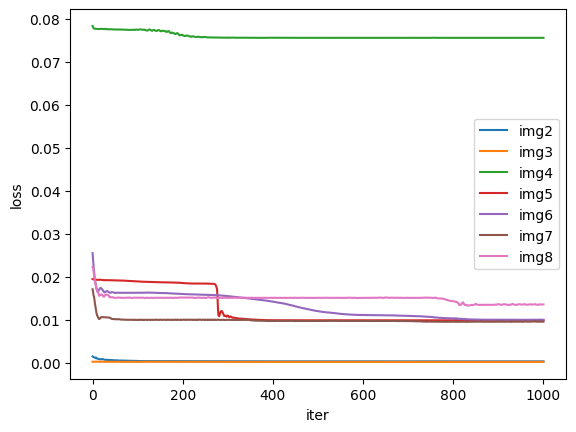

In [13]:
# plot  
x = np.linspace(0,steps,steps)
xx = np.zeros((7,steps))
for i in range(0,7):
    xx[i,:] = x
plt.plot(x, losses[1,:],x, losses[2,:],x, losses[3,:],x, losses[4,:],x, losses[5,:],x, losses[6,:],x, losses[7,:])
plt.ylabel('loss')
plt.xlabel('iter')
plt.legend(('img2','img3','img4','img5','img6','img7','img8'))
plt.show()

start image number 1:
iter: 0, loss is 0.03636624664068222
iter: 20, loss is 0.024637222290039062
iter: 40, loss is 0.018868593499064445
iter: 60, loss is 0.0008884634589776397
iter: 80, loss is 0.000901422172319144
iter: 100, loss is 0.00020730006508529186
iter: 120, loss is 0.00015498136053793132
iter: 140, loss is 0.00014864861441310495
start image number 2:
iter: 0, loss is 0.00011557771358639002
iter: 20, loss is 0.0007914822199381888
iter: 40, loss is 0.00015138357412070036
iter: 60, loss is 8.905994764063507e-05
iter: 80, loss is 7.786307105561718e-05
iter: 100, loss is 7.696464308537543e-05
iter: 120, loss is 7.610666943946853e-05
iter: 140, loss is 7.54048305680044e-05
start image number 3:
iter: 0, loss is 0.00016597387730143964
iter: 20, loss is 0.0026267310604453087
iter: 40, loss is 0.00029611762147396803
iter: 60, loss is 0.00013389307423494756
iter: 80, loss is 0.00010626754374243319
iter: 100, loss is 0.00010088441922562197
iter: 120, loss is 9.463966125622392e-05
iter:

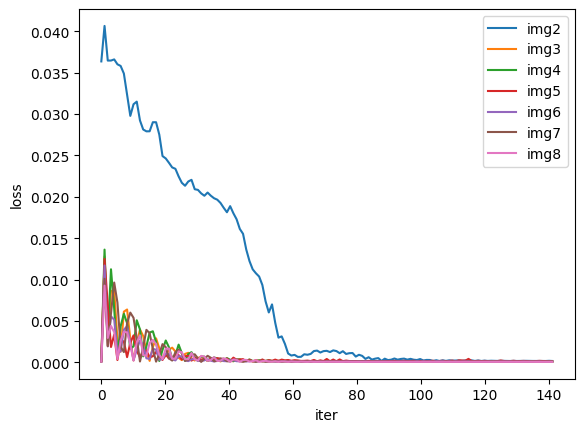

In [11]:
# optimizing with const velocity - phi and radius are fixed almost  
args.lrate = 0.15
imgs = []
for i in range(1,9):
    fname = os.path.join('./input/', '00' + str(i)+ '.png')
    imgs.append(imageio.imread(fname))
imgs = (np.array(imgs) / 255.).astype(np.float32)
imgs = torch.tensor(imgs).to(device)
N_rand = 500 #args.N_rand

args.precrop_frac = 0.5
dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)

coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
select_coords = coords[select_inds].long()  # (N_rand, 2)

init_param = torch.tensor([-108.0, -30.0, 4.0])
est_params = []

est_params.append(torch.clone(init_param.cpu()).detach().numpy())
steps = 140 + 1
all_losses = np.zeros((7,steps))
losses = np.zeros((8,steps))
for i in range(1,8):
    print(f'start image number {i}:')
    gt_image = imgs[i] 
    
    #param = torch.tensor([0.0, -30.0, 4.0]) good initial value
    if i < 2: 
        param = init_param.to(device)
    else: 
        init_param = init_param + torch.tensor(est_params[-1]) - torch.tensor(est_params[-2])
        param = init_param.to(device) 
    param.requires_grad = True 

    optimizer2 = torch.optim.Adam(params=[param], lr=args.lrate)
    
    mse_loss = torch.nn.MSELoss()
    predicted_poses = []
    rendered_rgb = []
    rendered_param = []
    for step in range(steps):
        render_poses = pose_spherical(param)
        c2w = torch.Tensor(render_poses).to(device)
        rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

        rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        batch_rays = torch.stack([rays_o, rays_d], 0)
        target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

        rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
        optimizer2.zero_grad()
        img_loss = mse_loss(rgb, target_s)
        img_loss.backward()
        optimizer2.step()
        #losses.append(torch.clone(img_loss.cpu()).detach().numpy())
        losses[i,step] = torch.clone(img_loss.cpu()).detach().numpy()
        if step%20 == 0:
            predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
            rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
            rendered_param.append(torch.clone(param.cpu()).detach().numpy())
            print(f'iter: {step}, loss is {img_loss}')
    est_params.append(rendered_param[-1])
    init_param = torch.tensor(rendered_param[-1])
# plot  
x = np.linspace(0,steps,steps)
xx = np.zeros((7,steps))
for i in range(0,7):
    xx[i,:] = x
plt.plot(x, losses[1,:],x, losses[2,:],x, losses[3,:],x, losses[4,:],x, losses[5,:],x, losses[6,:],x, losses[7,:])
plt.ylabel('loss')
plt.xlabel('iter')
plt.legend(('img2','img3','img4','img5','img6','img7','img8'))
plt.show()

/tmp/ipykernel_1508008/3890910047.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  est_params = torch.tensor(est_params)


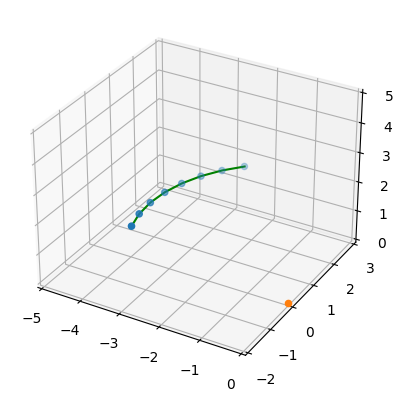

In [91]:
# Visualize 
est_poses = []
gt_poses = []

est_params = torch.tensor(est_params)
gt_params = torch.tensor([[-108.0000,  -30.0000,    4.0000],
        [ -99.00,  -30.0000,    4.0000],
        [ -90.00,  -30.0000,    4.0000],
        [ -81.00,  -30.0000,    4.0000],
        [ -72.00,  -30.0000,    4.0000],
        [ -63.00,  -30.0000,    4.0000],
        [ -54.00,  -30.0000,    4.0000],
        [ -45.00,  -30.0000,    4.0000]])

x = np.zeros((8,))
y = np.zeros((8,))
z = np.zeros((8,))
xe = np.zeros((8,))
ye = np.zeros((8,))
ze = np.zeros((8,))

for i in range(0,8): 
    est_poses.append(torch.clone(pose_spherical(est_params[i]).cpu()).detach().numpy())
    gt_poses.append(torch.clone(pose_spherical(gt_params[i]).cpu()).detach().numpy())

    x[i] = gt_poses[i][0,3]
    y[i] = gt_poses[i][1,3]
    z[i] = gt_poses[i][2,3]

    xe[i] = est_poses[i][0,3]
    ye[i] = est_poses[i][1,3]
    ze[i] = est_poses[i][2,3]

from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

# Data for a three-dimensional line

ax.plot3D(x, y, z, 'green')
#ax.plot3D(xe, ye, ze, 'red')
ax.set_xlim(-5, 0); ax.set_ylim(-2, 3); ax.set_zlim(0, 5)
ax.scatter3D(xe, ye, ze, cmap='Greens')
ax.scatter3D(0.0, 0.0, 0.0, cmap='Greens')

In [14]:
N_frames = len(os.listdir('./input/200images'))
imgs = []
for n in range(0, N_frames): 
    fname = os.path.join('./input/200images/', 'r_' + str(n)+ '.png')
    imgs.append(imageio.imread(fname))

imgs = (np.array(imgs) / 255.).astype(np.float32)
imgs = torch.tensor(imgs).to(device)


(200, 800, 800, 3)


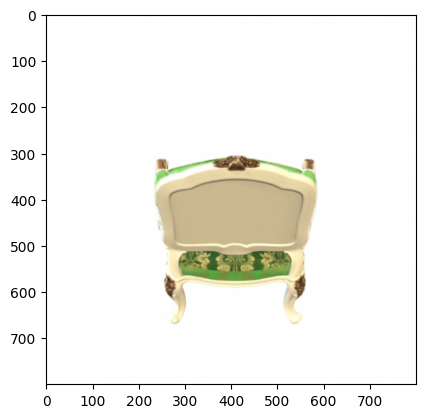

In [23]:
N_frames = len(os.listdir('./input/200images'))
all_imgs = []
imgs = []
for n in range(0, N_frames): 
    fname = os.path.join('./input/200images/', 'r_' + str(n)+ '.png')
    imgs.append(imageio.imread(fname))
#imgs.append(imageio.imread('./input/new/r_0.png'))
imgs = (np.array(imgs) / 255.).astype(np.float32)
all_imgs.append(imgs)
imgs = np.concatenate(all_imgs, 0)
imgs = imgs[...,:3]*imgs[...,-1:] + (1.-imgs[...,-1:])

rgbs = []
init_param = torch.tensor([0.0, -47.23, 4.0])
render_poses = pose_spherical(init_param)
with torch.no_grad():
    c2w = torch.Tensor(render_poses).to(device) 
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, c2w=c2w[:3,:4], **render_kwargs_test)
    rgbs.append(rgb.cpu().numpy())
    rgb8 = to8b(rgbs[-1])
rgb8 = (np.array(rgb8) / 255.).astype(np.float32)

print(imgs.shape)
plt.imshow(imgs[0]*0.5 + rgb8*0.5)

In [2]:
# optimizing with const velocity - theta and phi are changing  
# config  
args.lrate = 0.05
N_rand = 1024 #args.N_rand
args.precrop_frac = 0.5
steps = 200 + 1
init_param = torch.tensor([0.0, -47.23, 4.0])

### Load data - theta, phi and r for first imge (r_0.png) are (-47.23, 0.0, 4.0)
N_frames = len(os.listdir('./input/200images'))
all_imgs = []
imgs = []
for n in range(0, N_frames): 
    fname = os.path.join('./input/200images/', 'r_' + str(n)+ '.png')
    imgs.append(imageio.imread(fname))
#imgs.append(imageio.imread('./input/new/r_0.png'))
imgs = (np.array(imgs) / 255.).astype(np.float32)
all_imgs.append(imgs)
imgs = np.concatenate(all_imgs, 0)
imgs = imgs[...,:3]*imgs[...,-1:] + (1.-imgs[...,-1:])
imgs = torch.tensor(imgs).to(device)

# for white background 
#imgs = imgs[...,:3]*imgs[...,-1:] + (1.-imgs[...,-1:])

dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)

coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
select_coords = coords[select_inds].long()  # (N_rand, 2)

est_params = []
losses = np.zeros((N_frames,steps))
for i in range(1, N_frames):
    print(f'start image number {i}:')
    gt_image = imgs[i] 

    # constant velocity 
    if i < 3: 
        param = init_param.to(device)
    else:
        init_param = init_param + torch.tensor(est_params[-1]) - torch.tensor(est_params[-2])
        param = init_param.to(device)
    #param = init_param.to(device)
    param.requires_grad = True 

    optimizer2 = torch.optim.Adam(params=[param], lr=args.lrate)
    
    mse_loss = torch.nn.MSELoss()
    predicted_poses = []
    rendered_rgb = []
    rendered_param = []
    for step in range(steps):
        render_poses = pose_spherical(param)
        c2w = torch.Tensor(render_poses).to(device)
        rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

        rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        batch_rays = torch.stack([rays_o, rays_d], 0)
        target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

        rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
        optimizer2.zero_grad()
        img_loss = mse_loss(rgb, target_s)
        img_loss.backward()
        optimizer2.step()
        #losses.append(torch.clone(img_loss.cpu()).detach().numpy())
        losses[i,step] = torch.clone(img_loss.cpu()).detach().numpy()
        if step%50 == 0:
            predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
            rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
            rendered_param.append(torch.clone(param.cpu()).detach().numpy())
            print(f'iter: {step}, loss is {img_loss}')
    est_params.append(rendered_param[-1])
    init_param = torch.tensor(rendered_param[-1])


/home/eph133/miniconda3/envs/HashNeRF/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


start image number 1:
iter: 0, loss is 0.015920761972665787
iter: 50, loss is 0.00648932671174407
iter: 100, loss is 0.0023716602008789778
iter: 150, loss is 0.002373778959736228
iter: 200, loss is 0.0023682541213929653
start image number 2:
iter: 0, loss is 0.014237329363822937
iter: 50, loss is 0.005828181281685829
iter: 100, loss is 0.002379901707172394
iter: 150, loss is 0.0023713167756795883


KeyboardInterrupt: 

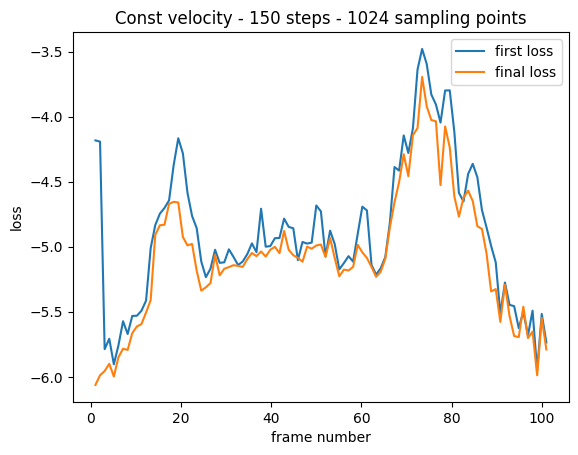

In [20]:
# plot  
from cv2 import log



first_loss = log(losses[:100,0])
final_loss = log(losses[:100,-1])
#x = np.linspace(0,N_frames-1,N_frames)
x = np.linspace(0,101,100)
plt.plot(x, first_loss, x, final_loss)
plt.ylabel('loss')
plt.xlabel('frame number')
plt.legend(('first loss','final loss'))
plt.title('Const velocity - 150 steps - 1024 sampling points')
plt.show()

start image number 1:
iter: 0, loss is 0.03504738584160805
iter: 20, loss is 0.0315646156668663
iter: 40, loss is 0.021227918565273285
iter: 60, loss is 0.010744687169790268
iter: 80, loss is 0.0017724698409438133
iter: 100, loss is 0.00021395567455329
iter: 120, loss is 0.00020394196326378733
iter: 140, loss is 0.0001835725415730849
start image number 2:
iter: 0, loss is 0.0445590503513813
iter: 20, loss is 0.03225763514637947
iter: 40, loss is 0.017581772059202194
iter: 60, loss is 0.0010943718953058124
iter: 80, loss is 0.0004739406576845795
iter: 100, loss is 0.0002184170443797484
iter: 120, loss is 0.00026226131012663245
iter: 140, loss is 0.00015305387205444276
start image number 3:
iter: 0, loss is 0.035637080669403076
iter: 20, loss is 0.035283513367176056
iter: 40, loss is 0.03441654518246651
iter: 60, loss is 0.032900333404541016
iter: 80, loss is 0.011556892655789852
iter: 100, loss is 0.000564351212233305
iter: 120, loss is 0.00021559206652455032
iter: 140, loss is 0.000184

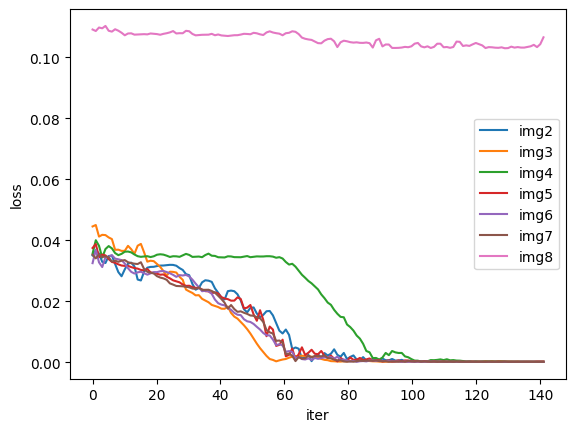

In [96]:
# optimizing with const velocity - 40 images phi and radius are fixed almost  
args.lrate = 0.15
N_frames = len(os.listdir('./input/40images'))
imgs = []

for i in range(0,10):
    fname = os.path.join('./input/40images', '00' + str(i)+ '.png')
    imgs.append(imageio.imread(fname))

for i in range(10,N_frames):
    fname = os.path.join('./input/40images', '0' + str(i)+ '.png')
    imgs.append(imageio.imread(fname))

imgs = (np.array(imgs) / 255.).astype(np.float32)
imgs = torch.tensor(imgs).to(device)

N_rand = 500 #args.N_rand

args.precrop_frac = 0.5
dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)

coords = torch.stack(torch.meshgrid(torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
select_coords = coords[select_inds].long()  # (N_rand, 2)

init_param = torch.tensor([-180.0, -30.0, 4.0])
est_params = []

est_params.append(torch.clone(init_param.cpu()).detach().numpy())
steps = 140 + 1
all_losses = np.zeros((N_frames-1,steps))
losses = np.zeros((N_frames,steps))
for i in range(1,N_frames):
    print(f'start image number {i}:')
    gt_image = imgs[i] 
    
    #param = torch.tensor([0.0, -30.0, 4.0]) good initial value
    '''if i < 2: 
        param = init_param.to(device)
    else: 
        init_param = init_param + torch.tensor(est_params[-1]) - torch.tensor(est_params[-2])
        param = init_param.to(device) '''
    param = init_param.to(device)
    param.requires_grad = True 

    optimizer2 = torch.optim.Adam(params=[param], lr=args.lrate)
    
    mse_loss = torch.nn.MSELoss()
    predicted_poses = []
    rendered_rgb = []
    rendered_param = []
    for step in range(steps):
        render_poses = pose_spherical(param)
        c2w = torch.Tensor(render_poses).to(device)
        rays_o, rays_d = get_rays(H, W, K, c2w.squeeze(0)) # [N, ro+rd, H, W, 3]

        rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        batch_rays = torch.stack([rays_o, rays_d], 0)
        target_s = gt_image[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

        rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays, **render_kwargs_test)
        optimizer2.zero_grad()
        img_loss = mse_loss(rgb, target_s)
        img_loss.backward()
        optimizer2.step()
        #losses.append(torch.clone(img_loss.cpu()).detach().numpy())
        losses[i,step] = torch.clone(img_loss.cpu()).detach().numpy()
        if step%20 == 0:
            predicted_poses.append(torch.clone(c2w.cpu()).detach().numpy())
            rendered_rgb.append(torch.clone(rgb.cpu()).detach().numpy())
            rendered_param.append(torch.clone(param.cpu()).detach().numpy())
            print(f'iter: {step}, loss is {img_loss}')
    est_params.append(rendered_param[-1])
    init_param = torch.tensor(rendered_param[-1])
# plot  
x = np.linspace(0,steps,steps)
xx = np.zeros((N_frames-1,steps))
for i in range(0,N_frames-1):
    xx[i,:] = x
plt.plot(x, losses[1,:],x, losses[2,:],x, losses[3,:],x, losses[4,:],x, losses[5,:],x, losses[6,:],x, losses[39,:])
plt.ylabel('loss')
plt.xlabel('iter')
plt.legend(('img2','img3','img4','img5','img6','img7','img8'))
plt.show()

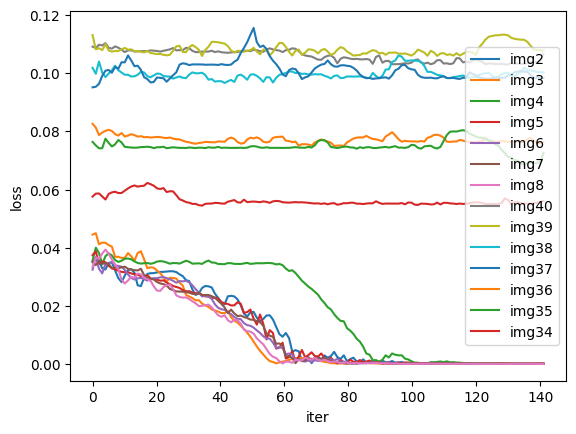

In [113]:
# plot  
x = np.linspace(0,steps,steps)
xx = np.zeros((N_frames-1,steps))
for i in range(0,N_frames-1):
    xx[i,:] = x
plt.plot(x, losses[1,:],x, losses[2,:],x, losses[3,:],x, losses[4,:],x, losses[5,:],x, losses[6,:],x, losses[7,:])
plt.plot(x, losses[39,:],x, losses[38,:],x, losses[37,:],x, losses[36,:],x, losses[35,:],x, losses[34,:],x, losses[33,:])
plt.ylabel('loss')
plt.xlabel('iter')
plt.legend(('img2','img3','img4','img5','img6','img7','img8','img40','img39','img38','img37','img36','img35','img34'))
plt.show()

/tmp/ipykernel_1508008/3596346026.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  est_params = torch.tensor(est_params)


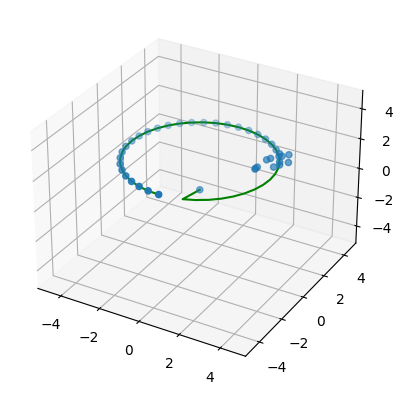

In [109]:
est_poses = []
gt_poses = []

est_params = torch.tensor(est_params)
gt_params = torch.zeros((N_frames,3))
gt_params[:,1] = -30.0
gt_params[:,2] = 4.0
gt_params[:,0] = torch.linspace(-180,180,N_frames+1)[:-1]

x = np.zeros((N_frames,));y = np.zeros((N_frames,));z = np.zeros((N_frames,));xe = np.zeros((N_frames,));ye = np.zeros((N_frames,));ze = np.zeros((N_frames,))

for i in range(0,N_frames-1): 
    est_poses.append(torch.clone(pose_spherical(est_params[i]).cpu()).detach().numpy())
    gt_poses.append(torch.clone(pose_spherical(gt_params[i]).cpu()).detach().numpy())

    x[i] = gt_poses[i][0,3]
    y[i] = gt_poses[i][1,3]
    z[i] = gt_poses[i][2,3]

    xe[i] = est_poses[i][0,3]
    ye[i] = est_poses[i][1,3]
    ze[i] = est_poses[i][2,3]

from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

# Data for a three-dimensional line

ax.plot3D(x, y, z, 'green')
#ax.plot3D(xe, ye, ze, 'red')
ax.set_xlim(-5, 5); ax.set_ylim(-5, 5); ax.set_zlim(-5, 5)
ax.scatter3D(xe, ye, ze, 'red', cmap='Reds')
#
# ax.scatter3D(0.0, 0.0, 0.0, cmap='Greens')

In [119]:

input_image = imageio.imread('./data/replica-room1/rgb/frame000000.jpg')
target = (np.array(input_image) / 255.).astype(np.float32)
target = torch.Tensor(target).to(device)

#target = target[...,:3]*target[...,-1:] + (1.-target[...,-1:])'''

In [120]:
target.shape

torch.Size([680, 1200, 3])